# Classification
## About Olist
- Olist is an e-commerce marketplace integerator connecting small businesses from all over Brazil to different customers.
    - small business can sign up on Olist and have their products promoted on various platforms (e.g., amazon) 
    - small business can sell directly to the Olist store and ship them directly using Olist logistics partners
    - Olist also provides market intellgience (market tendencies, pricing tools, performance tools)
## Objective:
- One of Olist's core business model is providing logistic and analytic support for sellers who release products in their platform.
- However, many sellers who sign up on Olist never generate any revenue for Olist (measured by the total prices of products bought for each seller)
- To efficiently allocate resources, ideally we should be able to identify potential big sellers and focus resources on them. So, I categorized the generated revenue variable as binary (0=no revenue, 1=any revenue) and then used a random forest model to predict this variable based on data when the seller initially joins Olist
- This can be used both as a prediction model to predict viable sellers and gain insights on what kind of variables make a viable seller

## Data processing:
- Combine multiple datasets
- Compute conversion days from mql to signing with Olist
- Compute the generated revenue for each seller
- Subset only relevant columns for analysis
    - removed columns are either unrelated to sellers or columns with ambiguous descriptions
- For null values: look at distribution of other columns of missing rows vs. non-missing rows
    -  distribution identical
    -  will drop those columns instead
    - for other null values will simply drop rows because there is no apparent patterns

In [1]:
# download packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# download datasets
mql = pd.read_csv('data/olist_marketing_qualified_leads_dataset.csv') # mql list
closed_deals = pd.read_csv('data/olist_closed_deals_dataset.csv') # mqls that converted to Olist customers
order_items = pd.read_csv('data/olist_order_items_dataset.csv') # products sold

In [2]:
# convert to datetime to find 
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'])
closed_deals['won_date'] = pd.to_datetime(closed_deals['won_date'])
mf = pd.merge(left=closed_deals, right=mql, on='mql_id', how='left') 
mf['conversion_length_full'] = mf['won_date'] - mf['first_contact_date']
mf['conversion_length_days'] = mf['conversion_length_full'].dt.days

# get generated revenue for each seller
mf_items = pd.merge(left=mf, right=order_items, on='seller_id', how='left')
mf_items['generated_revenue'] = mf_items.groupby('seller_id')['price'].transform('sum')
mf_revenue = mf_items[['seller_id', 'generated_revenue']]
mf_revenue = mf_revenue.drop_duplicates(subset=['seller_id', 'generated_revenue'], ignore_index=True)
mf_final = pd.merge(left=mf, right=mf_revenue, on='seller_id', how='left')
col_keep = ['business_segment', 'lead_type', 'has_company', 'has_gtin', 'average_stock', 'declared_product_catalog_size', 
            'declared_monthly_revenue', 'origin', 'conversion_length_days', 'generated_revenue']
mf_final = mf_final[col_keep]

In [3]:
mf_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 841
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   business_segment               841 non-null    object 
 1   lead_type                      836 non-null    object 
 2   has_company                    63 non-null     object 
 3   has_gtin                       64 non-null     object 
 4   average_stock                  66 non-null     object 
 5   declared_product_catalog_size  69 non-null     float64
 6   declared_monthly_revenue       842 non-null    float64
 7   origin                         828 non-null    object 
 8   conversion_length_days         842 non-null    int64  
 9   generated_revenue              842 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 72.4+ KB


In [4]:
# looking at missing values
missing_cols = ['has_company', 'has_gtin', 'average_stock', 'declared_product_catalog_size']
missing_df = []
for m in missing_cols:
    df = mf_final[mf_final[m].isnull()]
    missing_df.append(df)
missing_df.append(mf_final[mf_final.isnull()==False]) # df with no missing value as comparison
df_names = missing_cols + ["no_missing"]
comparison_cols = ['declared_monthly_revenue', 'generated_revenue', 'conversion_length_days', 'business_segment', 
                   'lead_type', 'origin']
comparison_col_short = ['dmr', 'gr', 'cld', 'bs', 'lt', 'origin']

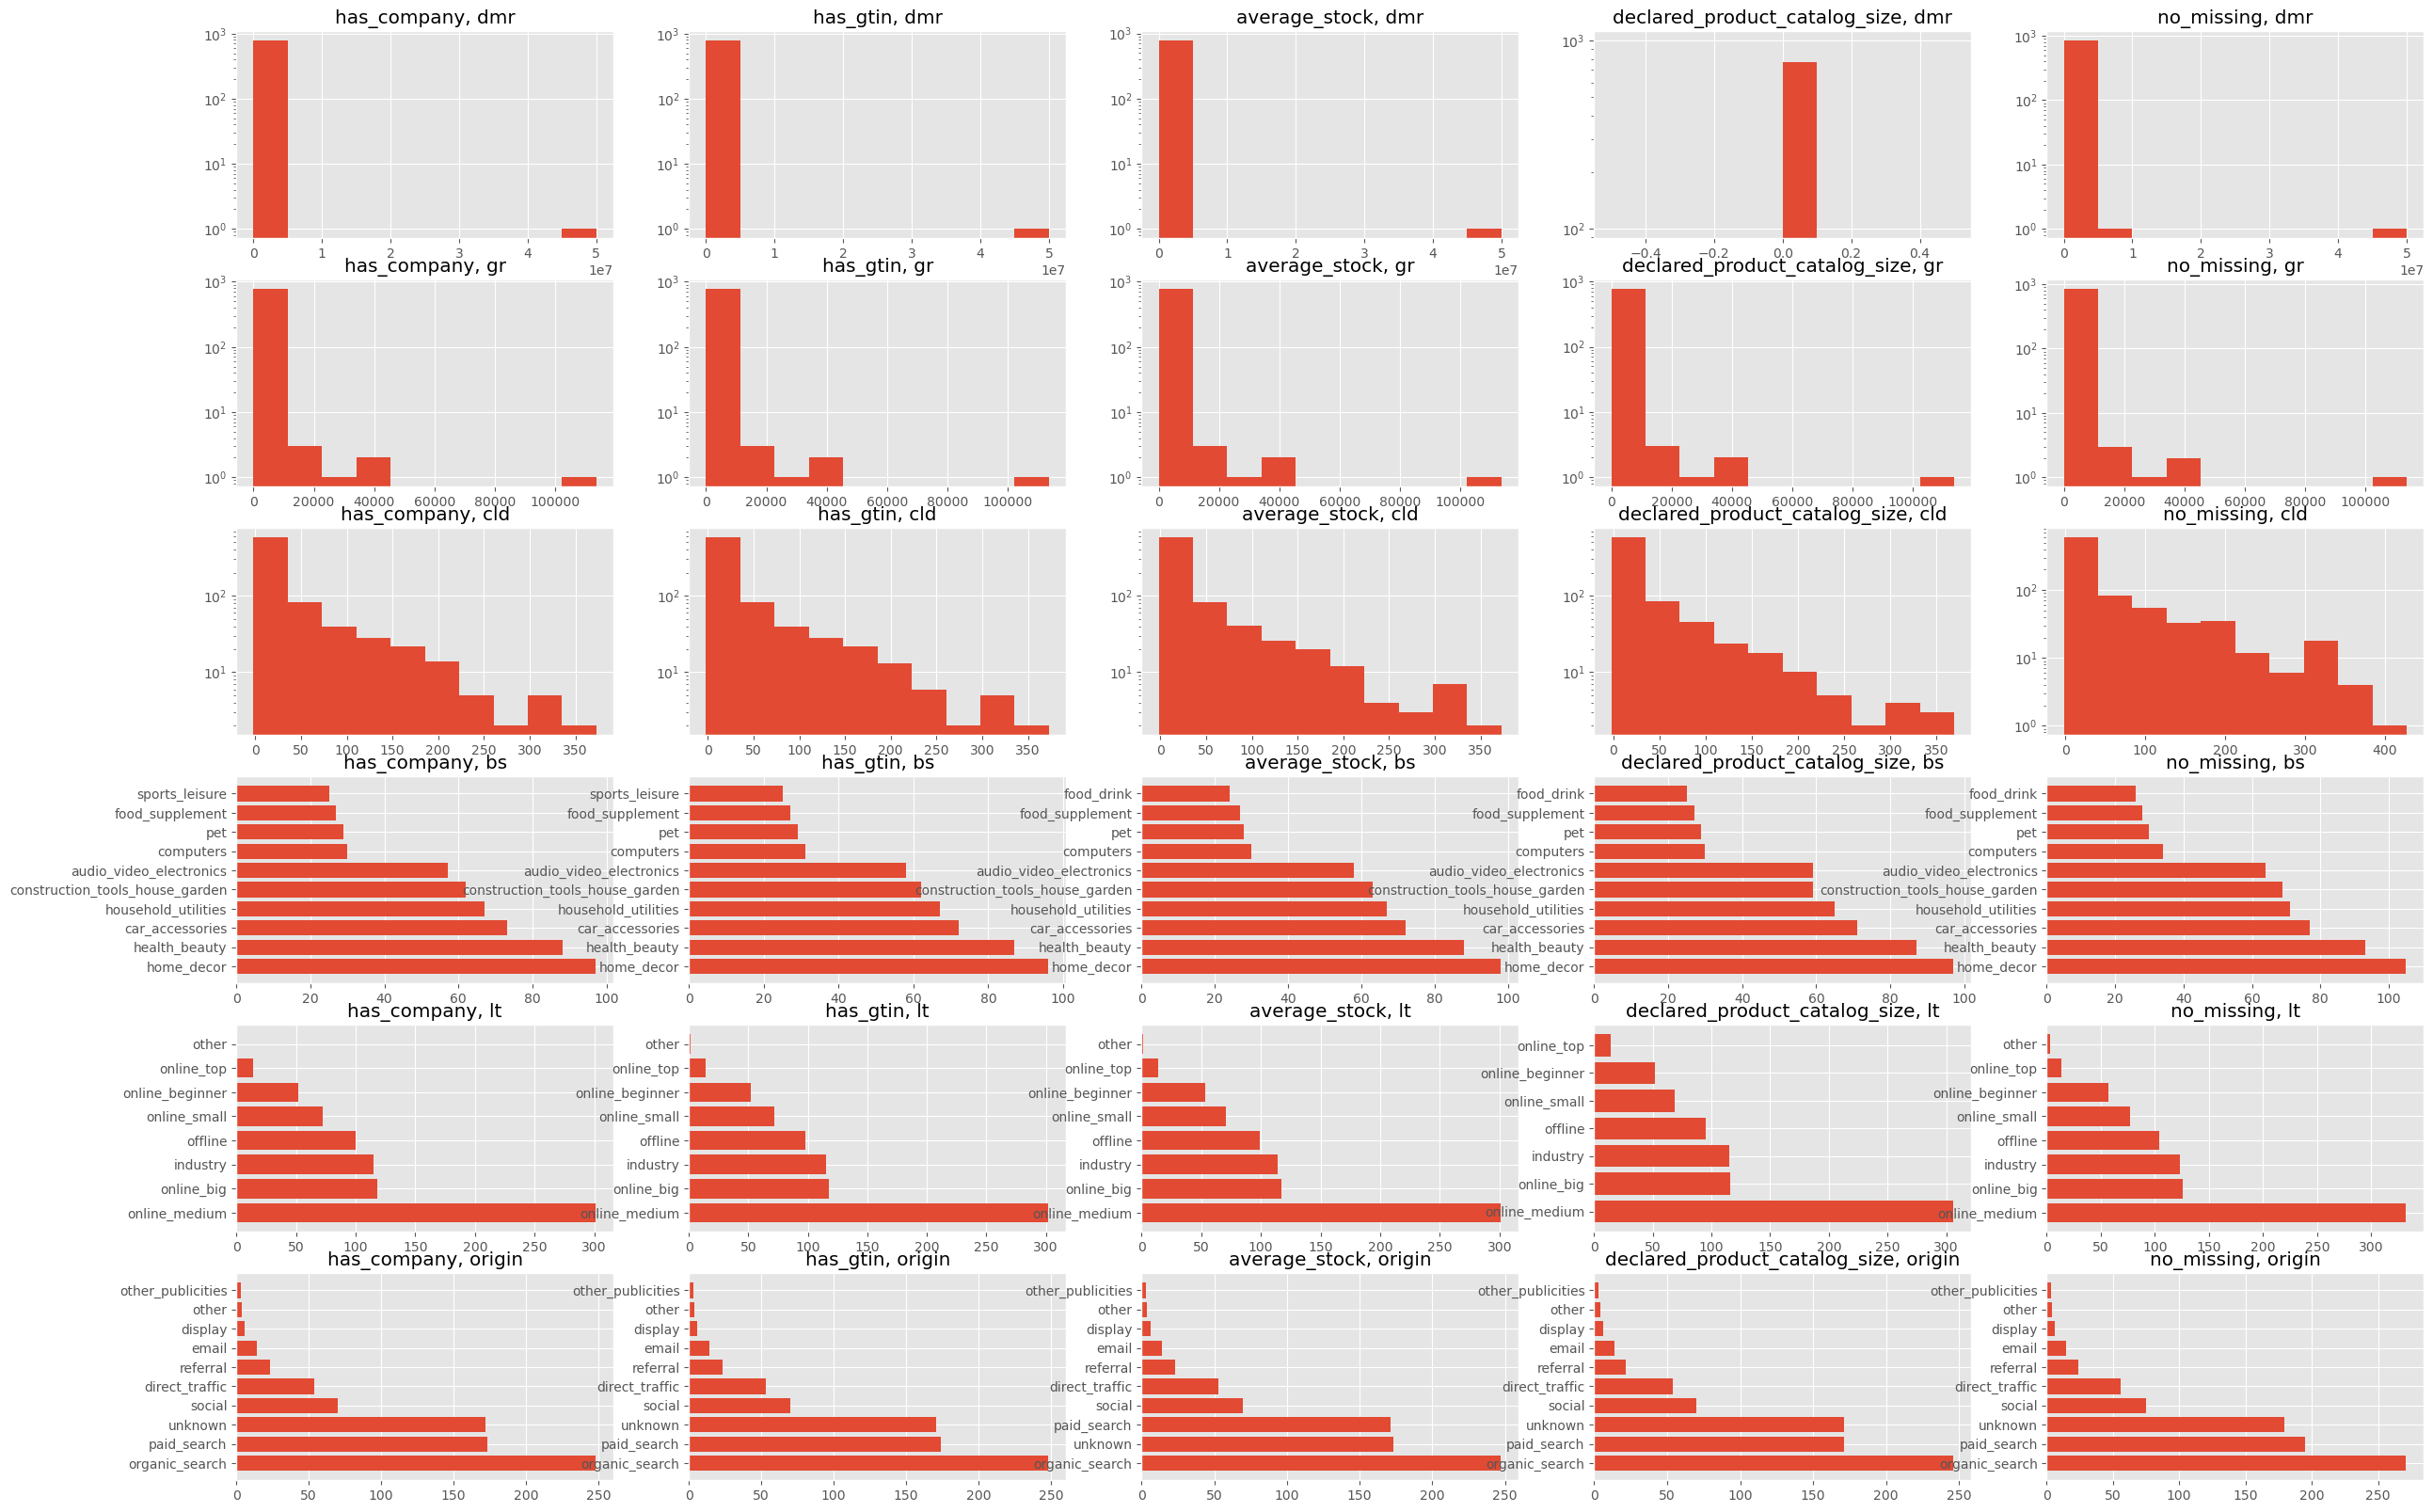

In [5]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(30,20))
for index, comp_cols in enumerate(comparison_cols):
    for i in range(5):
        if comp_cols == "business_segment":
            ax[index,i].barh(y=missing_df[i][comp_cols].value_counts().index[:10], 
                             width=missing_df[i][comp_cols].value_counts()[:10])
        elif comp_cols in ['lead_type', 'origin']:
            ax[index,i].barh(y=missing_df[i][comp_cols].value_counts().index, 
                             width=missing_df[i][comp_cols].value_counts())
        else:
            ax[index,i].hist(missing_df[i][comp_cols])
            ax[index,i].set_yscale('log')
        ax[index,i].set_title(f"{df_names[i]}, {comparison_col_short[index]}")
        

In [6]:
# will drop columns with majority missing values
mf_final = mf_final.drop(labels=missing_cols, axis=1)

In [7]:
mf_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 841
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   business_segment          841 non-null    object 
 1   lead_type                 836 non-null    object 
 2   declared_monthly_revenue  842 non-null    float64
 3   origin                    828 non-null    object 
 4   conversion_length_days    842 non-null    int64  
 5   generated_revenue         842 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 46.0+ KB


In [8]:
mf_final[mf_final['origin'].isnull()]

,business_segment,lead_type,declared_monthly_revenue,origin,conversion_length_days,generated_revenue
106,home_office_furniture,industry,0.0,NaN,6,0.0
318,party,online_medium,20000.0,NaN,155,0.0
398,computers,online_big,0.0,NaN,1,0.0
616,games_consoles,online_big,0.0,NaN,10,0.0
634,health_beauty,offline,0.0,NaN,7,0.0
658,construction_tools_house_garden,online_medium,0.0,NaN,4,319.0
685,health_beauty,online_medium,0.0,NaN,5,0.0
699,construction_tools_house_garden,online_small,130000.0,NaN,427,0.0
734,food_drink,industry,0.0,NaN,8,0.0
743,health_beauty,online_big,0.0,NaN,32,0.0


In [9]:
mf_final[mf_final['business_segment'].isnull()]

,business_segment,lead_type,declared_monthly_revenue,origin,conversion_length_days,generated_revenue
186,NaN,industry,0.0,unknown,296,0.0


In [10]:
mf_final[mf_final['lead_type'].isnull()]

,business_segment,lead_type,declared_monthly_revenue,origin,conversion_length_days,generated_revenue
96,household_utilities,NaN,0.0,unknown,87,0.0
393,home_decor,NaN,0.0,organic_search,72,0.0
445,pet,NaN,0.0,direct_traffic,32,740.4
447,audio_video_electronics,NaN,0.0,unknown,22,0.0
594,small_appliances,NaN,0.0,organic_search,10,44212.5
829,computers,NaN,0.0,organic_search,14,126.0


In [11]:
# can see no structural problems with other missing values, will drop those rows
mf_final = mf_final.dropna()
mf_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 0 to 841
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   business_segment          821 non-null    object 
 1   lead_type                 821 non-null    object 
 2   declared_monthly_revenue  821 non-null    float64
 3   origin                    821 non-null    object 
 4   conversion_length_days    821 non-null    int64  
 5   generated_revenue         821 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 44.9+ KB


## Objective:
- As shown below, majority of the sellers generate 0 revenue. So, I will create a binary variable (0=when revenue is 0, 1=else)

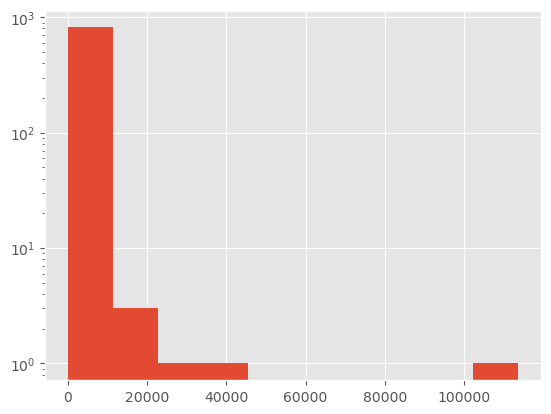

In [12]:
plt.hist(mf_final['generated_revenue'])
plt.yscale('log')

In [13]:
# creating target variable
mf_final.loc[mf_final['generated_revenue']==0, 'target'] = 0
mf_final.loc[mf_final['generated_revenue']>0, 'target'] = 1
mf_final = mf_final.drop(labels='generated_revenue', axis=1)

In [14]:
mf_final['target'].value_counts()

0.0    448
1.0    373
Name: target, dtype: int64

## Feature Engineering/Selection
- There are several categorical variables. I will dummy encode these variables.
- Since, the number of dummy variables (~40) far exceeds the number of original variables (5), I will use a feature selection method to reduce the features and prevent overfitting
- I will apply a filtering method using "mutual information" as the scoring criteria because the data contains a mix of categorical and numerical variables
- This will be done using the k-select-best technique, which selects the top-k features based on the scoring criteria
- This k value is a hyperparameter, so I will be using a grid search to select a range of k values and train-validate using a random forest.
- I will choose the k value that balances the number of features and AUC score

In [15]:
mf_final

,business_segment,lead_type,declared_monthly_revenue,origin,conversion_length_days,target
0,pet,online_medium,0.0,organic_search,5,1.0
1,car_accessories,industry,0.0,referral,34,0.0
2,home_appliances,online_big,0.0,organic_search,63,1.0
3,food_drink,online_small,0.0,paid_search,3,0.0
4,home_appliances,industry,0.0,unknown,267,1.0
...,...,...,...,...,...,...
837,home_decor,offline,0.0,organic_search,126,0.0
838,construction_tools_house_garden,online_big,200000.0,organic_search,132,0.0
839,computers,online_medium,0.0,paid_search,12,0.0
840,pet,online_beginner,0.0,social,30,0.0


In [16]:
bs_dummy = pd.get_dummies(mf_final.loc[:,'business_segment'])
lt_dummy = pd.get_dummies(mf_final.loc[:,'lead_type'])
o_dummy = pd.get_dummies(mf_final.loc[:,'origin'])
mf_select = pd.concat([mf_final, bs_dummy, lt_dummy, o_dummy], axis=1)
mf_select = mf_select.drop(labels=['business_segment', 'lead_type', 'origin'], axis=1)

In [17]:
# train-test split
X = mf_select.drop(labels=['target'], axis=1)
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
Y = mf_select['target']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm,Y, test_size=0.2, random_state=1234)

In [18]:
# perform k-select-best using mutual information as the scoring criteria
# loop through various k values and compute AUC score
# find balance between k value and AUC score
k_values = [k for k in range(len(mf_final.columns), len(mf_select.columns))] # should not have less than the original number of features before dummy encoding
auc_scores = []
best_score = 0
for k in k_values:  
    # select the top k features using SelectKBest and 
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # train a random forest classifier on the selected features
    clf = RandomForestClassifier(n_estimators=1000, random_state=1234)
    clf.fit(X_train_selected, y_train)
    
    # compute the AUC score on the test set
    y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(score)

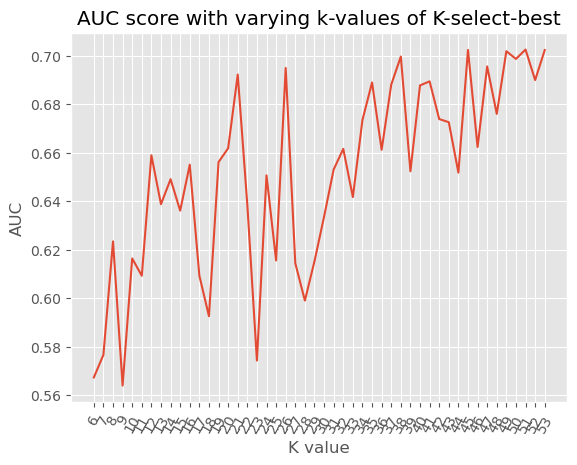

In [19]:
plt.plot(auc_scores)
plt.xticks(ticks=np.linspace(0,len(auc_scores)-1, len(auc_scores)), labels=k_values, rotation=60)
plt.xlabel("K value")
plt.ylabel("AUC")
plt.title("AUC score with varying k-values of K-select-best")
plt.show()

- K=49 yields balance between high AUC score and number of features

Text(0.5, 0, 'Random Forest Feature Importance')

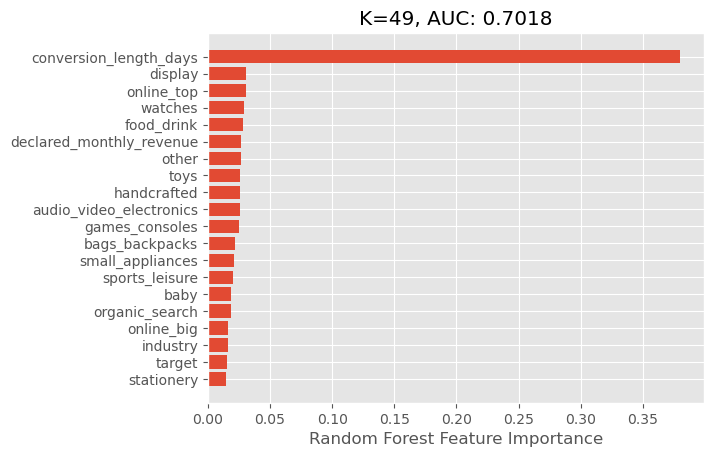

In [20]:
k_best = 49
selector = SelectKBest(mutual_info_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
# train a random forest classifier on the selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=1234)
clf.fit(X_train_selected, y_train)

# compute the AUC score on the test set
y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
score = np.round(roc_auc_score(y_test, y_pred_proba),4)

sorted_idx = clf.feature_importances_.argsort()
plt.barh(mf_select.columns[sorted_idx][-20:], clf.feature_importances_[sorted_idx][-20:])
plt.title(f"K={k_best}, AUC: {score}")
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

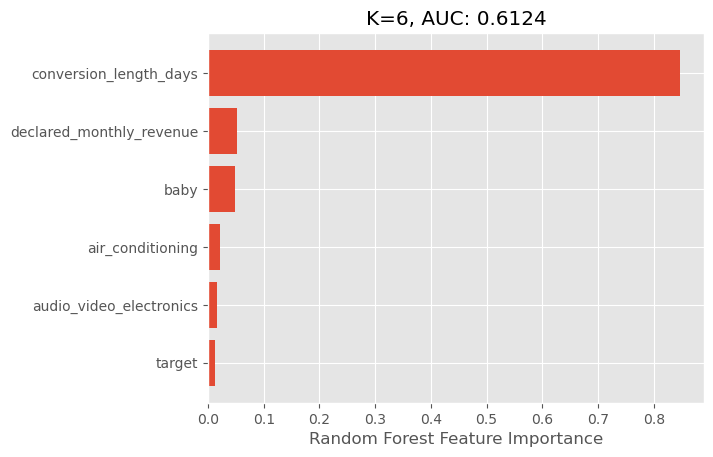

In [21]:
selector = SelectKBest(mutual_info_classif, k=6)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
# train a random forest classifier on the selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=1234)
clf.fit(X_train_selected, y_train)

# compute the AUC score on the test set
y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
score = np.round(roc_auc_score(y_test, y_pred_proba),4)

sorted_idx = clf.feature_importances_.argsort()
plt.barh(mf_select.columns[sorted_idx][-20:], clf.feature_importances_[sorted_idx][-20:])
plt.title(f"K=6, AUC: {score}")
plt.xlabel("Random Forest Feature Importance")

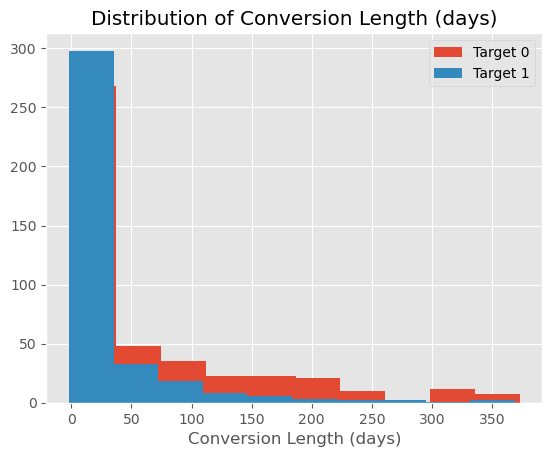

In [22]:
cld_t0 = mf_select[mf_select['target']==0]['conversion_length_days']
cld_t1 = mf_select[mf_select['target']==1]['conversion_length_days']
plt.hist(cld_t0, label='Target 0')
plt.hist(cld_t1, label='Target 1')
plt.title("Distribution of Conversion Length (days)")
plt.xlabel("Conversion Length (days)")
plt.legend()
plt.show()

In [28]:
# Mann-Whitney and Kolomogroc-Smirnov test to test if the distribution of conversion lengths are the same for target=0 and target=1
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp

u_stat, u_p_value = mannwhitneyu(cld_t0, cld_t1)
ks_stat, ks_p_value = ks_2samp(cld_t0, cld_t1)

# Print the results
print(f"Mann-Whitney U statistic = {u_stat:.6f}")
print(f"p-value = {u_p_value}")
print(f"KS test statistic: {ks_stat}")
print(f"P-value: {ks_p_value}")

Mann-Whitney U statistic = 108685.500000
p-value = 1.0746503711787884e-13
KS test statistic: 0.22524296246648792
P-value: 1.4858303853617161e-09


- The two distributions are significantly different (p<0.05). So we can reject the null hypothesis that these two distributions come from the same distribution
- There is definitely a difference in the conversion length between sellers who generate no revenue (target=0) and positive reveneu (target=1)

## Results:
- I plotted the k-values as a function of the AUC score. As shown above, the AUC score is constantly oscillating which means its likely overfitting. Additionally, the AUC score only reaches a score of 0.7, which is moderate
- The random forest feature importantance is similar for both when k=5 (lowest) and k=49 (best). The conversion length (days) is by far the most relevant feature
- This represents the number of days, it took for a seller to first show interest in Olist and finally partner with Olist
- Looking at the histogram of the conversion length between sellers who generated no revenue (target=0) and positive revenue (target=1), the distributions are relatively similar. However, the distribution of target=1 is more left skewed.
- This means sellers who generate revenue are more likely to sign up quicker with Olist. Around, 50 days seems to be cutoff
- This is useful for marketing and sales representatives who work to secure more sellers on Olist. After 50 days of negotiation, resources should be moved away from these potential sellers because they are not likely to generate any revenue
- As for prediction, this random forest model is very unstable. For future reference, a different model and feature selection may make a difference. However, this is may due to the data itself

## Conclusion:
- The number of days it takes to convert a potential seller to a official seller is the largest indicator of the seller's potential revenue
- After 50 days, resources should be moved away from these potential sellers
- As for prediction, the model is too unstable to be usable